# 4 Stars?

Backstory: This object was found by Erin Howard in TESS. At first glance I thought it could be a double-double EB, 4 stars? I saw at least 4 distinct eclipse depths. I was puzzled that the eclipse separations were very uniform though... so we started down this path of looking further!

After a couple interrupted hours of hacking on this, I had a few plots, and the next day made this my "TESS Tuesday" [thread](https://twitter.com/jradavenport/status/1293268299761868800) on Twitter

Then the experts showed up and asked good Q's, which led me to 1) do a better job refining the eclipse period to see there is no big O-C offset, and 2) look at small details in the eclipse depths to realize it's definitely a scattered light/background subtraction issue.

SO, this potentially interesting and confusing system turns out to be.... BORING. Chalk another one up to systematics and optimism :)

This notebook preserved for future lessons, and maybe some useful code to copy/paste

In [56]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from astropy.stats import funcs
from matplotlib.colors import LogNorm
from astropy.table import Table
from astropy.timeseries import LombScargle, BoxLeastSquares
from scipy.optimize import curve_fit


In [57]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
tess_dir = '/Users/james/Desktop/tess/'

In [4]:
files = glob(tess_dir + '*/*.fits', recursive=True)
len(files)

494415

In [5]:
tic = '140659980'

In [6]:
file_Series = pd.Series(files)
obj_Series = file_Series.str.split('-', expand=True)[2]

In [7]:
TICs = file_Series[(obj_Series.str.contains(tic))]
TICs

2318      /Users/james/Desktop/tess/sector010/tess201908...
156155    /Users/james/Desktop/tess/sector011/tess201911...
180899    /Users/james/Desktop/tess/sector002/tess201823...
198956    /Users/james/Desktop/tess/sector005/tess201831...
225899    /Users/james/Desktop/tess/sector003/tess201826...
259459    /Users/james/Desktop/tess/sector013/tess201916...
360813    /Users/james/Desktop/tess/sector012/tess201914...
411963    /Users/james/Desktop/tess/sector008/tess201903...
425430    /Users/james/Desktop/tess/sector006/tess201834...
450724    /Users/james/Desktop/tess/sector001/tess201820...
466657    /Users/james/Desktop/tess/sector007/tess201900...
487285    /Users/james/Desktop/tess/sector009/tess201905...
dtype: object

In [8]:
tbl = Table.read(TICs.values[0], format='fits')
tbl['PDCSAP_FLUX_reg'] = tbl['PDCSAP_FLUX'] - np.nanmedian(tbl['PDCSAP_FLUX'])
df_tbl = tbl.to_pandas()

for k in range(1, TICs.size):
    tbl = Table.read(TICs.values[k], format='fits')
    tbl['PDCSAP_FLUX_reg'] = tbl['PDCSAP_FLUX'] - np.nanmedian(tbl['PDCSAP_FLUX'])
    df_tbl = pd.concat([df_tbl, tbl.to_pandas()], ignore_index=True, sort=False)

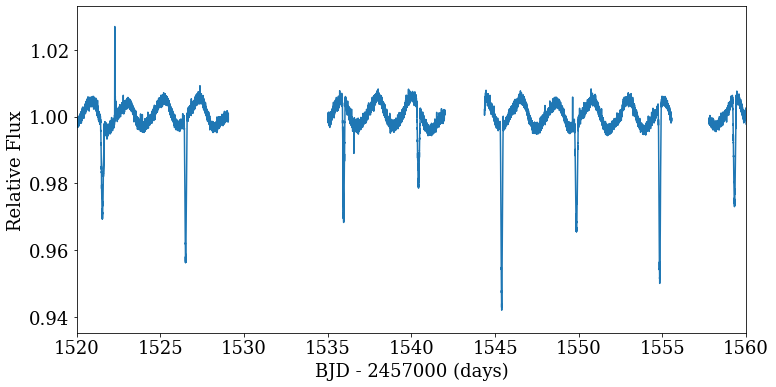

In [252]:
normflux = df_tbl['PDCSAP_FLUX_reg'] / np.nanmedian(df_tbl['PDCSAP_FLUX']) + 1
normerr = df_tbl['PDCSAP_FLUX_ERR'] / np.nanmedian(df_tbl['PDCSAP_FLUX'])

plt.figure(figsize=(12,6))
plt.plot(df_tbl['TIME'], 
         normflux)
plt.xlim(1520,1560)
plt.xlabel('BJD - 2457000 (days)')
plt.ylabel('Relative Flux')
plt.savefig('/Users/james/Dropbox/lc.png', bbox_inches='tight', pad_inches=0.25, dpi=100)

By *my eye* there seems to be, like, 4 different depths going on here, even though the spacing suggests they're all the same period...

In [10]:
AOK = np.where((df_tbl['QUALITY'] == 0) & 
               ((df_tbl['TIME'] < 1347) | (df_tbl['TIME'] > 1350)) & 
               np.isfinite(df_tbl['TIME']) & np.isfinite(normflux) & np.isfinite(normerr))[0]


LS = LombScargle(df_tbl['TIME'].values[AOK], normflux.values[AOK], dy=normerr.values[AOK])
frequency, power = LS.autopower(minimum_frequency=1./80.,
                                maximum_frequency=1./0.1,
                                samples_per_peak=7)

best_frequency = frequency[np.argmax(power)]
P1 = 1./best_frequency
print(P1)

2.141308165521647


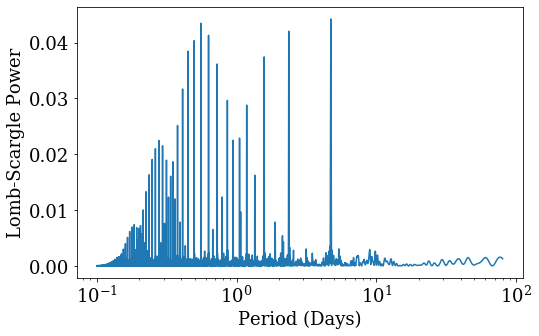

In [253]:
plt.figure(figsize=(8,5))
plt.plot(1./frequency, power)
plt.xscale('log')
plt.xlabel('Period (Days)')
plt.ylabel('Lomb-Scargle Power')
plt.savefig('/Users/james/Dropbox/LS.png', bbox_inches='tight', pad_inches=0.25, dpi=100)

(0.98, 1.015)

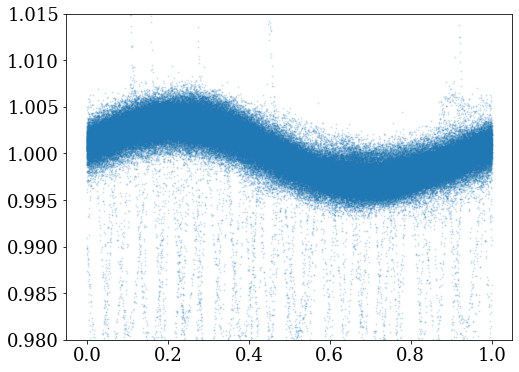

In [12]:
plt.figure(figsize=(8,6))
plt.scatter((df_tbl['TIME'].values[AOK] % P1) / P1, normflux.values[AOK], s=1, alpha=0.15)
plt.ylim(.98,1.015)

In [13]:
def phzmed(time, flux, per, bsize=500):
    '''
    phase-fold and return median model back in TIME units
    '''
    phz1 = np.hstack(((time % per)/per-1, (time % per)/per))
    pfl1 = np.tile(flux, 2)

    ss1 = np.argsort(phz1)
    psmo1 = pd.Series(pfl1[ss1]).rolling(bsize, center=True).median()

    ind1 = np.hstack((np.arange(len(time)), np.arange(len(time))))
    out1 = np.where((phz1[ss1] >= -0.5) & (phz1[ss1] < 0.5))[0]
    sout1 = np.argsort(ind1[ss1][out1])
    
    model1 = psmo1[out1].values[sout1]
    
    return model1

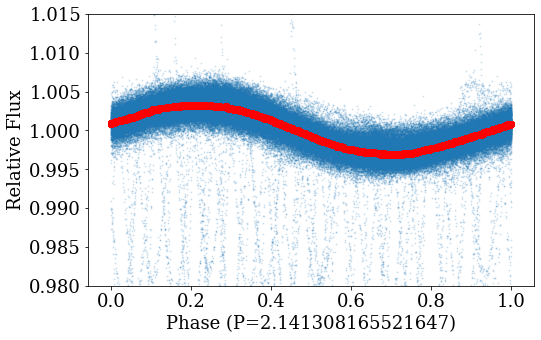

In [254]:
model1 = phzmed(df_tbl['TIME'].values[AOK] , normflux.values[AOK], P1, bsize=1000)

plt.figure(figsize=(8,5))
plt.scatter((df_tbl['TIME'].values[AOK] % P1) / P1, normflux.values[AOK], s=1, alpha=0.15)
plt.scatter((df_tbl['TIME'].values[AOK] % P1) / P1, model1, s=30, alpha=0.5,c='r')
plt.ylim(.98,1.015)
plt.xlabel('Phase (P='+str(P1)+')')
plt.ylabel('Relative Flux')

# plt.show()

# plt.figure()
# plt.scatter(df_tbl['TIME'].values[AOK], normflux.values[AOK], s=1, alpha=0.15)
# plt.scatter(df_tbl['TIME'].values[AOK], model1, s=1, alpha=0.15)
# plt.ylim(.98,1.015)
plt.savefig('/Users/james/Dropbox/model1.png', bbox_inches='tight', pad_inches=0.25, dpi=100)

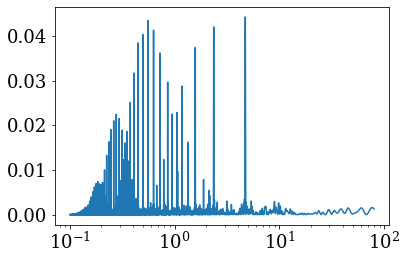

In [195]:
LS = LombScargle(df_tbl['TIME'].values[AOK], normflux.values[AOK] - model1, dy=normerr.values[AOK])
frequency, power = LS.autopower(minimum_frequency=1./80.,
                                maximum_frequency=1./0.1,
                                samples_per_peak=7)


plt.plot(1./frequency, power)
plt.xscale('log')
# plt.xlim(1, 10)

In [16]:
g4 = np.where((1./frequency > 4))[0]

P2 = 1./ frequency[g4[np.argmax(power[g4])]] * 2

P2

9.445292234925342

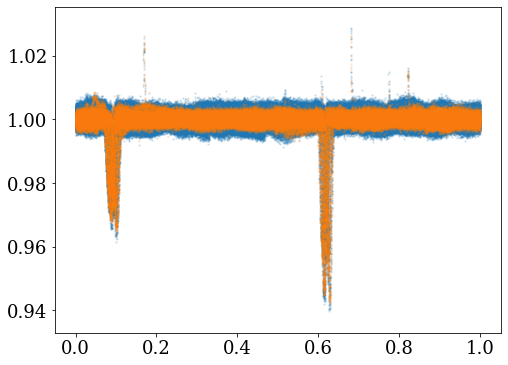

In [17]:
plt.figure(figsize=(8,6))
plt.scatter((df_tbl['TIME'].values[AOK] % P2) / P2, normflux.values[AOK] , s=2, alpha=0.15)

plt.scatter((df_tbl['TIME'].values[AOK] % P2) / P2, normflux.values[AOK] - model1 + 1, s=2, alpha=0.15)
# plt.ylim(.98,1.015)
# plt.xlim(0.55,.7)

wtf.... blah!

This clearly isn't the right period. Wwe need to use something besides L-S.

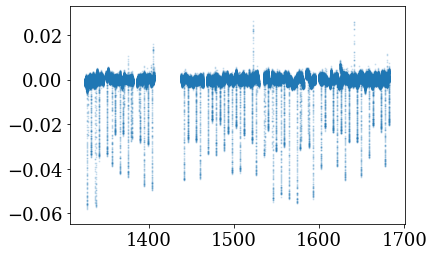

In [19]:
plt.scatter(df_tbl['TIME'].values[AOK], normflux.values[AOK] - model1, s=1, alpha=0.15)

In [20]:
bls = BoxLeastSquares(df_tbl['TIME'][AOK], normflux.values[AOK] - model1, 
                      dy=normflux.values[AOK])

In [21]:
blsP = bls.power(1./frequency, 0.05, method='fast', objective='snr',)

In [22]:
blsP

          depth: array([3.59642741e-02, 1.80777824e-02, 2.48451312e-02, ...,
       1.29658503e-05, 1.40636439e-05, 1.49078526e-05])
      depth_err: array([0.11349812, 0.0944246 , 0.1148896 , ..., 0.00451685, 0.00453965,
       0.00451685])
      depth_snr: array([0.3168711 , 0.19145205, 0.21625222, ..., 0.00287055, 0.00309796,
       0.0033005 ])
       duration: array([0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05])
 log_likelihood: array([5.02235403e-02, 1.83374389e-02, 2.33915532e-02, ...,
       8.24229891e-06, 8.72417689e-06, 1.08854400e-05])
      objective: 'snr'
         period: array([80.        , 77.51882842, 75.18693242, ...,  0.1000081 ,
        0.10000409,  0.10000009])
          power: array([0.3168711 , 0.19145205, 0.21625222, ..., 0.00287055, 0.00309796,
       0.0033005 ])
   transit_time: array([2.53966032e+01, 1.98965201e+01, 6.05387521e+01, ...,
       9.31317088e-03, 7.23437960e-02, 3.03701776e-02])

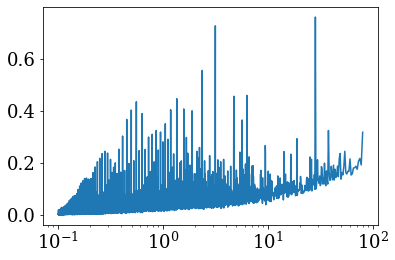

In [188]:
plt.plot(blsP['period'],blsP['power'])
plt.xscale("log")

In [49]:
P2b = blsP['period'][np.argmax(blsP['power'])] / 3. 
P2b

9.441471655544513

In [280]:
blsP2 = bls.power(np.linspace(9.438,9.4405,10000), 0.05, method='fast', objective='snr',)
blsP2['period'][np.argmax(blsP2['power'])]

9.439996449644966

In [281]:
P2b = blsP2['period'][np.argmax(blsP2['power'])]
P2b

9.439996449644966

In [262]:
g10 = np.where((blsP['period'] < 10))[0]

P3 = blsP['period'][g10[np.argmax(blsP['power'][g10])]]

P3 / P2b

0.33336144223635383

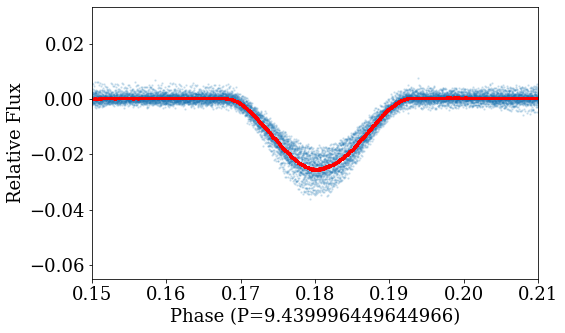

In [282]:
model2 = phzmed(df_tbl['TIME'].values[AOK] , normflux.values[AOK] - model1, P2b, bsize=300)

plt.figure(figsize=(8,5))

plt.scatter((df_tbl['TIME'].values[AOK] % P2b) / P2b, normflux.values[AOK] - model1 , s=2, alpha=0.15)
plt.scatter((df_tbl['TIME'].values[AOK] % P2b) / P2b, model2 , s=4, alpha=0.55, c='r')

plt.xlim(0.15,0.21)
plt.xlabel('Phase (P='+str(P2b)+')')
plt.ylabel('Relative Flux')

plt.savefig('/Users/james/Dropbox/E2.png', bbox_inches='tight', pad_inches=0.25, dpi=100)

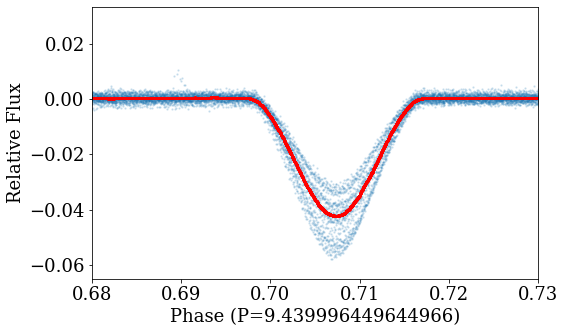

In [283]:
plt.figure(figsize=(8,5))
plt.scatter((df_tbl['TIME'].values[AOK] % P2b) / P2b, normflux.values[AOK] - model1 , s=2, alpha=0.15)
plt.scatter((df_tbl['TIME'].values[AOK] % P2b) / P2b, model2 , s=4, alpha=0.55, c='r')
plt.xlabel('Phase (P='+str(P2b)+')')
plt.ylabel('Relative Flux')


plt.xlim(0.68, .73)
plt.savefig('/Users/james/Dropbox/E1.png', bbox_inches='tight', pad_inches=0.25, dpi=100)

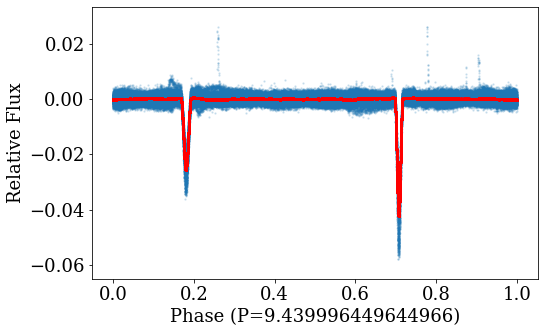

In [284]:
plt.figure(figsize=(8,5))

plt.scatter((df_tbl['TIME'].values[AOK] % P2b) / P2b, normflux.values[AOK] - model1 , s=2, alpha=0.15)
plt.scatter((df_tbl['TIME'].values[AOK] % P2b) / P2b, model2 , s=4, alpha=0.55, c='r')

# plt.xlim(0.13,0.18)
plt.xlabel('Phase (P='+str(P2b)+')')
plt.ylabel('Relative Flux')


plt.savefig('/Users/james/Dropbox/P2b.png', bbox_inches='tight', pad_inches=0.25, dpi=100)

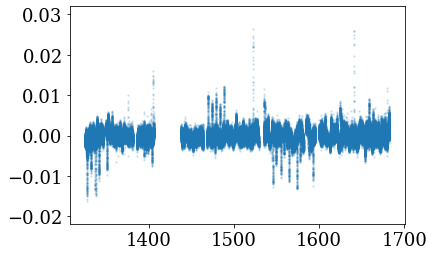

In [274]:
plt.scatter((df_tbl['TIME'].values[AOK]), normflux.values[AOK] - model1 - model2 , s=2, alpha=0.15)

OK, this *looks* still like 1 period, but the depths are ALL over the place...

Let's take a different approach: we know the period & rough eclipse times now, let's use a Gaussian to quickly measure the depths & center times of each primary & secondary eclipse


In [54]:
def _gaus(x, a, b, x0, sigma):
    """
    Simple Gaussian function
    Parameters
    ----------
    x : float or 1-d numpy array
        The data to evaluate the Gaussian over
    a : float
        the amplitude
    b : float
        the constant offset
    x0 : float
        the center of the Gaussian
    sigma : float
        the width of the Gaussian
    Returns
    -------
    Array or float of same type as input (x).
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b


In [203]:
def Gtrace(t, f, per, A, B, phz0, sigma):
    '''
    
    '''
    
    Ntot0 = int((np.nanmax(t) - np.nanmin(t)) / per) + 1
    phase = (t % per)/per
    p0=[A, B, phz0, sigma]
            
    for k in range(Ntot0):
        trng = np.where((t >= (np.nanmin(t) + k*per)) & 
                        (t <= (np.nanmin(t) + (k+1)*per)))[0]
        if len(trng) > 1000:
            popt, pcov = curve_fit(_gaus, phase[trng], f[trng], p0=p0)
            popt = np.append(popt, np.nanmin(t) + k*per + popt[2])
            
            if popt[4] < np.nanmax(t):
                if k==0:
                    pout = popt
                else:
                    pout = np.vstack((pout, popt))
    return pout

In [285]:
# Primary Eclipse
Ecl1 = Gtrace((df_tbl['TIME'].values[AOK]), normflux.values[AOK] - model1, P2b, -0.04, 0., 0.682,  0.02)

# Secondary Eclipse
Ecl2 = Gtrace((df_tbl['TIME'].values[AOK]), normflux.values[AOK] - model1, P2b, -0.025, 0., 0.155,  0.02)

In [286]:
print(Ecl1.shape,Ecl2.shape)

(35, 5) (35, 5)


In [287]:
min(df_tbl['TIME'])

1325.295214286634

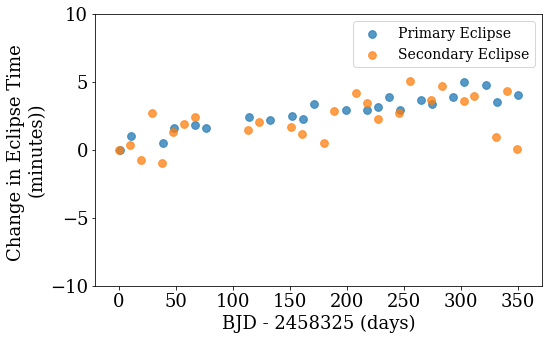

In [288]:
plt.figure(figsize=(8,5))
plt.scatter(Ecl1[:,4]-1325, (Ecl1[:,2] - Ecl1[0,2])*P2b * 24*60, c='C0', alpha=0.75, label='Primary Eclipse', s=60)
plt.scatter(Ecl2[:,4]-1325, (Ecl2[:,2] - Ecl2[0,2])*P2b * 24*60, c='C1', alpha=0.75, label='Secondary Eclipse', s=60)

plt.ylim(-10,10)
plt.ylabel('Change in Eclipse Time \n(minutes))')
plt.xlabel('BJD - 2458325 (days)')
plt.legend(fontsize=14)

plt.savefig('/Users/james/Dropbox/O-C.png', bbox_inches='tight', pad_inches=0.25, dpi=100)

(-0.01, 0.01)

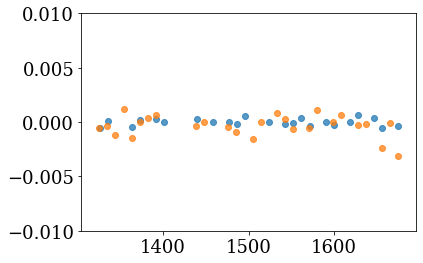

In [290]:
# maybe some trend of the eclipses shifting about the average O-C trend?

fok = np.where(((Ecl1[:,2] - Ecl1[0,2])*P2b > -0.07) & ((Ecl1[:,2] - Ecl1[0,2])*P2b < 0.02))[0]
fit = np.polyfit(Ecl1[fok,4], (Ecl1[fok,2] - Ecl1[0,2])*P2b, 1)

plt.scatter(Ecl1[:,4], (Ecl1[:,2] - Ecl1[0,2])*P2b - np.polyval(fit,Ecl1[:,4]) , c='C0', alpha=0.75)
plt.scatter(Ecl2[:,4], (Ecl2[:,2] - Ecl2[0,2])*P2b - np.polyval(fit,Ecl2[:,4]), c='C1', alpha=0.75)

plt.ylim(-0.01,0.01)

In [291]:
perr = np.sqrt(np.diag(pcov))
perr

array([6.27203687e-04, 4.37879214e-05, 5.04519894e-05, 5.06365326e-05])

/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


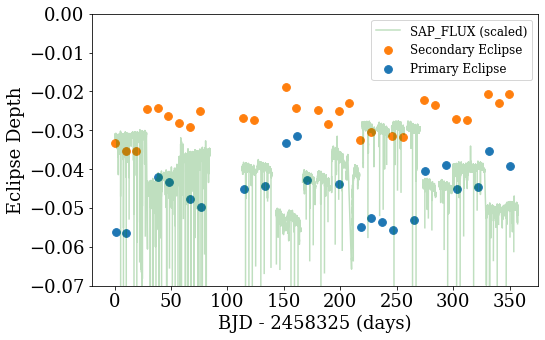

In [318]:
# ok, now lets look at eclipse depth vs time...

plt.figure(figsize=(8,5))
ok2 = np.where((Ecl2[:,0] < -0.01))[0]
ok1 = np.where((Ecl1[:,0] < -0.01))[0]
plt.scatter(Ecl2[ok2,4]-1325, Ecl2[ok2,0], label='Secondary Eclipse',c='C1',s=60)
plt.scatter(Ecl1[ok1,4]-1325, Ecl1[ok1,0], label='Primary Eclipse', c='C0', s=60)

ss = np.argsort(df_tbl['TIME'].values)
plt.plot(df_tbl['TIME'].values[ss]-1325, 
         (df_tbl['SAP_FLUX'].values[ss]/np.nanmedian(df_tbl['SAP_FLUX'])-1)/5 - 0.04, 
            c='g', alpha=0.25, label='SAP_FLUX (scaled)')

# plt.xlim(1300,1700)
plt.ylim(-0.07,0)
plt.xlabel('BJD - 2458325 (days)')

plt.ylabel('Eclipse Depth')
plt.legend(fontsize=12)

plt.savefig('/Users/james/Dropbox/dpeth.png', bbox_inches='tight', pad_inches=0.25, dpi=100)

In [ ]:
# ok, now lets look at eclipse depth vs time...

plt.figure(figsize=(8,5))
ok2 = np.where((Ecl2[:,0] < -0.01))[0]
ok1 = np.where((Ecl1[:,0] < -0.01))[0]
plt.scatter(Ecl2[ok2,4]-1325, Ecl2[ok2,0], label='Secondary Eclipse',c='C1',s=60)
plt.scatter(Ecl1[ok1,4]-1325, Ecl1[ok1,0], label='Primary Eclipse', c='C0', s=60)


# plt.xlim(1300,1700)
plt.ylim(-0.07,0)
plt.xlabel('BJD - 2458325 (days)')

plt.ylabel('Eclipse Depth')
# WTF?!
plt.legend(fontsize=14)
# 
# plt.savefig('/Users/james/Dropbox/dpeth.png', bbox_inches='tight', pad_inches=0.25, dpi=100)

(-0.07, 0)

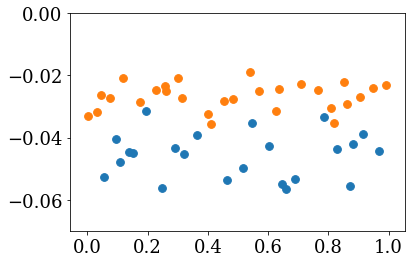

In [299]:
plt.scatter((Ecl2[ok2,4] % P1)/P1, Ecl2[ok2,0], label='Secondary Eclipse',c='C1',s=60)
plt.scatter((Ecl1[ok1,4] % P1)/P1, Ecl1[ok1,0], label='Primary Eclipse', c='C0', s=60)

plt.ylim(-0.07,0)

Text(0, 0.5, 'Eclipse Depth')

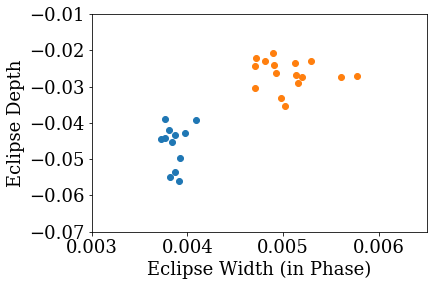

In [293]:
plt.scatter(Ecl1[:,3],Ecl1[:,0], )
plt.scatter(Ecl2[:,3],Ecl2[:,0], )
plt.ylim(-0.07,-0.01)
plt.xlim(0.003,.0065)
plt.xlabel('Eclipse Width (in Phase)')
plt.ylabel('Eclipse Depth')

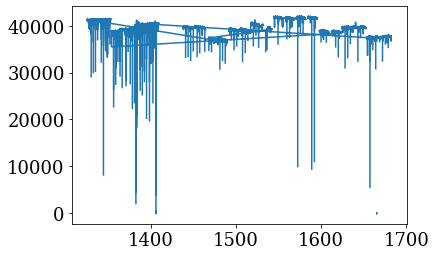

In [300]:
# normflux = df_tbl['PDCSAP_FLUX_reg'] / np.nanmedian(df_tbl['PDCSAP_FLUX']) + 1
plt.plot(df_tbl['TIME'], df_tbl['SAP_FLUX'])
